In [1]:
import pandas as pd
import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
import seaborn as sns

In [2]:
data = pd.read_csv("jobs.csv")
data.shape
data.replace(' ', np.nan, inplace= True)
df = pd.DataFrame(data)
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,NaN,NaN,...,"Salary range for this position is: $42,405 - $...",NaN,NaN,NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,NaN,2011-06-24T00:00:00.000,2019-11-26T00:00:00.000
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,NaN,F,...,NaN,"In addition to applying through this website, ...",NaN,NaN,NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,NaN,2012-01-26T00:00:00.000,2019-11-26T00:00:00.000
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-11-26T00:00:00.000
3,132292,NYC HOUSING AUTHORITY,Internal,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-11-26T00:00:00.000
4,133921,NYC HOUSING AUTHORITY,Internal,50,Temporary Painter,PAINTER,91830,0,Maintenance & Operations,F,...,SPECIAL NOTE: 1. This is a temporary assig...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirement.,2014-01-09T00:00:00.000,NaN,2014-01-08T00:00:00.000,2019-11-26T00:00:00.000


# 3. Feature selection
We are going to use the data satisfying the following conditions.

'Salary Range From' > 0
'Salary Range To' > 0
'Salary Frequency' = Annual
'Job Category' !=NaN
'Minimum Qual Requirements' != NaN
'Preferred Skills' ! = NaN

In [3]:
df = df.dropna(subset=['Salary Range From', 'Salary Range To','Job Category', 'Salary Frequency', 'Minimum Qual Requirements', 'Preferred Skills']) 
df = df[(df['Salary Frequency'] =='Annual') & (df['Salary Range From'] > 0) & (df['Salary Range To']  >0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2394 entries, 2 to 3019
Data columns (total 28 columns):
Job ID                           2394 non-null int64
Agency                           2394 non-null object
Posting Type                     2394 non-null object
# Of Positions                   2394 non-null int64
Business Title                   2394 non-null object
Civil Service Title              2394 non-null object
Title Code No                    2394 non-null object
Level                            2394 non-null object
Job Category                     2394 non-null object
Full-Time/Part-Time indicator    2217 non-null object
Salary Range From                2394 non-null float64
Salary Range To                  2394 non-null float64
Salary Frequency                 2394 non-null object
Work Location                    2394 non-null object
Division/Work Unit               2394 non-null object
Job Description                  2394 non-null object
Minimum Qual Requirements    

In [4]:
df.describe()

,Job ID,# Of Positions,Salary Range From,Salary Range To,Recruitment Contact
count,2394.000000,2394.000000,2394.000000,2394.000000,0.0
mean,384479.475355,1.714703,64796.357277,94047.490192,NaN
std,51189.750275,3.544013,20220.252096,35789.672734,NaN
min,132292.000000,1.000000,26457.000000,32665.000000,NaN
25%,379095.000000,1.000000,52524.000000,68181.000000,NaN
50%,403522.000000,1.000000,61237.000000,85000.000000,NaN
75%,415816.500000,1.000000,74990.000000,110000.000000,NaN
max,424117.000000,62.000000,218587.000000,234402.000000,NaN


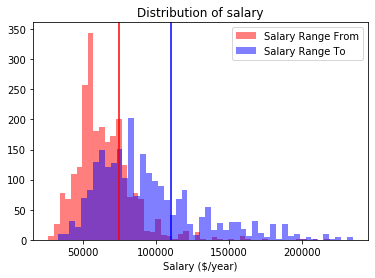

In [5]:
plt.hist(df['Salary Range From'], bins=50, alpha=  0.5, color='r', label='Salary Range From')
plt.hist(df['Salary Range To'],     bins=50, alpha = 0.5, color='b', label='Salary Range To')
plt.xlabel('Salary ($/year)')
plt.title('Distribution of salary')

plt.axvline(df['Salary Range From'].quantile(.75), color='r')
MinSalary=df['Salary Range From'].quantile(.75)
plt.axvline(df['Salary Range To'].quantile(.75), color='b')
MaxSalary=df['Salary Range To'].quantile(.75)

plt.legend()
plt.show()

In [6]:
df.loc[  (df['Salary Range From'] > MinSalary), 'Min_Salary75'] = 1
df.loc[~(df['Salary Range From'] > MinSalary), 'Min_Salary75'] = 0

df.loc[ (df['Salary Range To'] > MaxSalary), 'Max_Salary75'] = 1
df.loc[~(df['Salary Range To'] > MaxSalary), 'Max_Salary75'] = 0

df['Min_Salary75'] = df['Min_Salary75'].astype(int)
df['Max_Salary75'] = df['Max_Salary75'].astype(int)

df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date,Min_Salary75,Max_Salary75
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-11-26T00:00:00.000,0,0
3,132292,NYC HOUSING AUTHORITY,Internal,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-11-26T00:00:00.000,0,0
6,137433,DEPT OF HEALTH/MENTAL HYGIENE,Internal,1,Contract Analyst,PROCUREMENT ANALYST,12158,3,"Finance, Accounting, & Procurement",F,...,NaN,"42-09 28th Street, Long Island City, NY",NaN,New York City residency is generally required ...,2013-12-09T00:00:00.000,NaN,2013-12-09T00:00:00.000,2019-11-26T00:00:00.000,0,0
7,138531,DEPT OF ENVIRONMENT PROTECTION,Internal,1,Associate Chemist,ASSOCIATE CHEMIST,21822,2,"Health Public Safety, Inspections, & Enforcement",F,...,35 Hours per week/Day shift,96-05 Horace Harding Expway,NaN,New York City residency is generally required ...,2013-12-20T00:00:00.000,NaN,2014-07-25T00:00:00.000,2019-11-26T00:00:00.000,0,0
8,151131,NYC HOUSING AUTHORITY,External,1,Cost Estimating Manager,ADMINISTRATIVE STAFF ANALYST (,1002D,0,"Engineering, Architecture, & Planning",F,...,NaN,NaN,NaN,NYCHA has no residency requirements.,2014-06-25T00:00:00.000,NaN,2014-07-07T00:00:00.000,2019-11-26T00:00:00.000,1,0


# A. What are the highest paid Skills in the US market?

In [7]:
def clensing(df_series):
    df = df_series.replace('[^a-zA-Z ]',' ', regex = True)
    df = df.str.lower()
    return df

df['MinQualReq'] = clensing(df['Minimum Qual Requirements'])
df['PrefSkills']= clensing(df['Preferred Skills'])

In [8]:
import nltk
#To downlaod just stopwords:
nltk.download('stopwords');
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guptak14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guptak14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
def identify_tokens(row):
    prefferedSkill = row['Preferred Skills']
    tokens = nltk.word_tokenize(prefferedSkill)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['PreferredSWord'] = df.apply(identify_tokens, axis=1)

In [10]:
from nltk.stem import PorterStemmer
stemming = PorterStemmer()

In [11]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['PreferredSWord']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

df['stem_meaningful'] = df.apply(remove_stops, axis=1)
df['stem_meaningful'].head()

2    [A, High, School, Diploma, GED, CDL, Driver, L...
3    [A, High, School, Diploma, GED, CDL, Driver, L...
6    [Strong, analytical, background, advanced, pro...
7    [In, order, apply, position, candidate, must, ...
8    [Five, years, managerial, supervisory, experie...
Name: stem_meaningful, dtype: object

In [12]:
def rejoin_words(row):
    my_list = row['stem_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

df['processedSkills'] = df.apply(rejoin_words, axis=1)

In [13]:
df['processedSkills'].head()

2    A High School Diploma GED CDL Driver License E...
3    A High School Diploma GED CDL Driver License E...
6    Strong analytical background advanced proficie...
7    In order apply position candidate must permane...
8    Five years managerial supervisory experience E...
Name: processedSkills, dtype: object

In [14]:
def calc_tfidf(docs, count, tfidf):
    bag = count.fit_transform(docs)
    t = tfidf.fit_transform(bag)
    return bag, t

def conc_text(texts, flags):
    pos = ""
    neg = ""
    for (t,f) in zip(texts.values, flags.values):
        if f >0:
            pos = pos + t + " "
        else:
            neg = neg + t + " "
    
    return [pos,neg]

tfidf = TfidfTransformer(use_idf = True, norm ='l2', smooth_idf = True)
count = CountVectorizer()

def stats(count, tfidf):
    df1 = pd.DataFrame(list(count.vocabulary_.items()),columns=['word','id'])
    df1 = df1.sort_values('id').reset_index()
    dfx = pd.DataFrame(tfidf.toarray().T)
    dfx.columns = ['tf-idf for high salary', 'tf-idf for low salary']
    df1 = pd.concat([df1, dfx], axis=1)
    df1['diff'] = df1['tf-idf for high salary']- df1['tf-idf for low salary']
    return df1

In [15]:
docs4 = conc_text(df['processedSkills'], df['Max_Salary75'])
bag4, tfidf4 = calc_tfidf(docs4, count, tfidf)
#print(tfidf4)
df4 = stats(count, tfidf4)
skillHigh=df4.nlargest(10,'diff')
skillHigh

,index,word,id,tf-idf for high salary,tf-idf for low salary,diff
1666,2,experience,1666,0.538734,0.412020,0.126714
4799,1,years,4799,0.155634,0.077053,0.078581
2602,139,management,2602,0.214721,0.136372,0.078349
3425,249,project,3425,0.128215,0.070479,0.057736
3875,51,security,3875,0.062176,0.013301,0.048876
943,478,construction,943,0.092299,0.044183,0.048116
4310,102,technical,4310,0.069128,0.038374,0.030754
4088,107,staff,4088,0.054839,0.024614,0.030225
1530,106,engineering,1530,0.065266,0.037456,0.027810
2412,69,knowledge,2412,0.210087,0.183154,0.026933


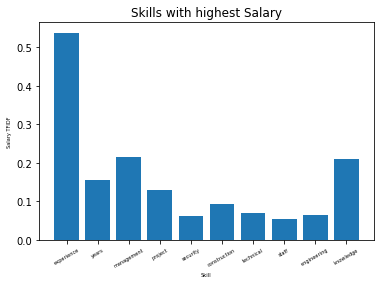

In [16]:
# this is for plotting purpose
index = np.arange(len(skillHigh['word']))    
plt.bar(index, skillHigh['tf-idf for high salary'])
plt.xlabel('Skill', fontsize=5)
plt.ylabel('Salary TFIDF', fontsize=5)
plt.xticks(index,skillHigh['word'], fontsize=5, rotation=30)
plt.title('Skills with highest Salary')
plt.show()

In [17]:
highestPaidSkill=df4.nlargest(10,'diff')
skillsToFilter=highestPaidSkill['word']
skillsToFilterStr="|".join(skillsToFilter)
skillsToFilterStr

'experience|years|management|project|security|construction|technical|staff|engineering|knowledge'

In [18]:
skillHighSalay= df[df['processedSkills'].str.contains(skillsToFilterStr)][['Salary Range To','processedSkills']]
skillHighSalaygrouped = (skillHighSalay.groupby(['processedSkills'])['Salary Range To'].mean().nlargest(10)).reset_index()
skillHighSalaygrouped

,processedSkills,Salary Range To
0,Valid holder CCISO Certified Chief Information...,234402.0
1,A Degree accounting related field Five years s...,224749.0
2,A minimum ten years satisfactory professional ...,224749.0
3,The Deputy Commissioner position requires exce...,218587.0
4,A degree accredited college economics finance ...,217244.0
5,Candidate must six years paid experience archi...,217244.0
6,Education Experience Preferred A degree accred...,217244.0
7,Preferred Education Experience Minimum years s...,217244.0
8,The Deputy Commissioner position requires exce...,209585.0
9,At least eight years experience communications...,202744.0


# B. What are the job categories, which involve above mentioned niche skills? 

In [19]:
jobcateHighSalay= df[df['processedSkills'].str.contains(skillsToFilterStr)][['Job Category','processedSkills']]
jobcategoWithSkill = (jobcateHighSalay.groupby(['Job Category'])['processedSkills'].count().nlargest(10)).reset_index()
jobcategoWithSkill

,Job Category,processedSkills
0,"Engineering, Architecture, & Planning",401
1,"Technology, Data & Innovation",230
2,Legal Affairs,161
3,"Public Safety, Inspections, & Enforcement",124
4,"Finance, Accounting, & Procurement",111
5,Constituent Services & Community Programs,100
6,"Policy, Research & Analysis",91
7,Administration & Human Resources,70
8,"Finance, Accounting, & Procurement Policy, Res...",63
9,Health,56


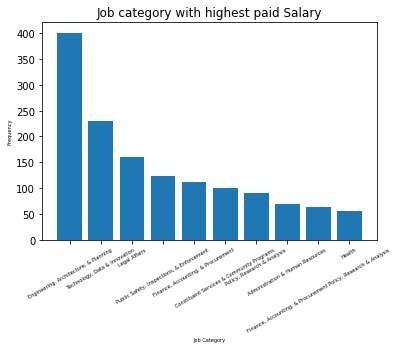

In [20]:
# this is for plotting purpose
index = np.arange(len(jobcategoWithSkill['Job Category']))    
plt.bar(index, jobcategoWithSkill['processedSkills'])
plt.xlabel('Job Category', fontsize=5)
plt.ylabel('Frequency', fontsize=5)
plt.xticks(index,jobcategoWithSkill['Job Category'], fontsize=5, rotation=30)
plt.title('Job category with highest paid Salary')
plt.show()

# C. Applying clustering concepts, please depict visually what are the different salary ranges based on job category and years of experience.

In [21]:
df['experience'] = df['Minimum Qual Requirements'].str.lower().str.extract(r'(\w+)\syear.+experience')
yearsAlphaToNumber={'two':2, 'three':3, 'half':0.5, 'one':1,
                   'four':4, 'five':5,  'ten':10, '10':10,
                   'six':6, 'eight':8,'seven':7,
                    '5':5, '4':4, '3':3, '6':6}
df['experience'] = df['experience'].str.lower().map(yearsAlphaToNumber)


In [22]:
df['experience'].value_counts()

1.0     808
2.0     440
4.0     302
3.0     228
5.0     198
6.0      55
0.5      32
7.0      17
8.0      10
10.0      6
Name: experience, dtype: int64

In [23]:
df['experience'].isna().sum()

298

Text(0.5, 1, 'Number of Missing Values')

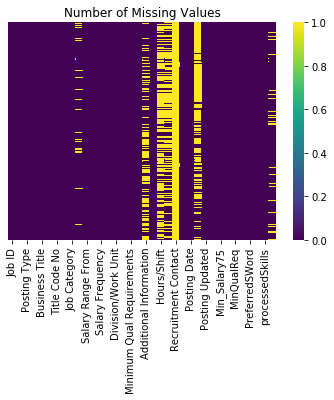

In [24]:
sns.heatmap(df.isna(),yticklabels=False, cmap='viridis', cbar=True)
plt.title("Number of Missing Values")

In [25]:
df['experience'].fillna(1,inplace=True)
df['experience'].isna().sum()

0

In [26]:
df['experience'].value_counts()

1.0     1106
2.0      440
4.0      302
3.0      228
5.0      198
6.0       55
0.5       32
7.0       17
8.0       10
10.0       6
Name: experience, dtype: int64

In [27]:
high_sal_range = (df.groupby(['Job Category','experience'])['Salary Range To'].mean().nlargest(10)).reset_index()
#high_sal_range

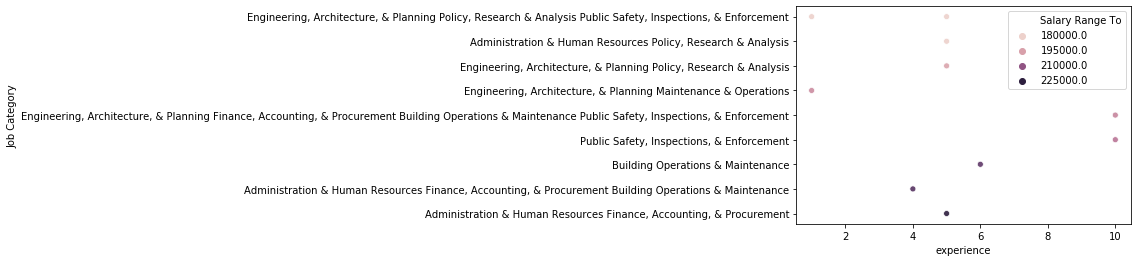

In [28]:
# using color for the 3rd dimension
#!pip install --upgrade pip
#!pip install -U seaborn

sc = sns.scatterplot(high_sal_range['experience'],high_sal_range['Job Category'],  
                hue=high_sal_range['Salary Range To'], alpha=0.9)